## CSCI E-116 Assignment #4
### TSA Air Travel Prediction with Prophet
### Roger Zeng
**10/04/2022**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
# Data files to import and associated column data types
infile = 'W09e_tsa.xlsx'

# import data from file named above
train_travel = pd.read_excel(infile, sheet_name='train', na_values=["NA"], header=0, index_col=None)
test_travel = pd.read_excel(infile, sheet_name='test', na_values=["NA"], header=0, index_col=None)

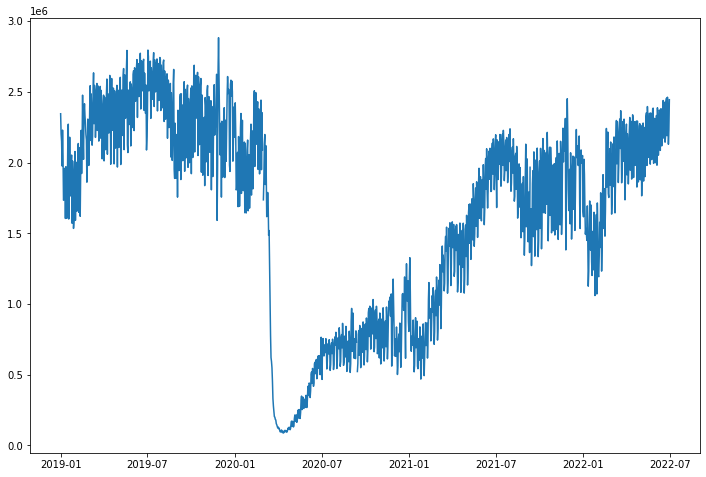

In [4]:
# Daily air travel plots
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(train_travel['ds'], train_travel['travel_train'])
plt.show()


In [5]:
#  Using Facebook Prophet for Store Time Series Forecasting
from prophet import Prophet
from sklearn.metrics import mean_squared_error


In [6]:
train_travel.rename(columns={'ds': "ds" , 'travel_train' : "y"}, inplace=True)
tt_model = Prophet(interval_width=0.95,
                           yearly_seasonality=True, 
                           weekly_seasonality=True, 
                           daily_seasonality=True,
                  )
#tt_model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=1)
#tt_model.add_seasonality(name='yearly', period=365, fourier_order=10, prior_scale=1)
  
#Fit model
tt_model.fit(train_travel)

#Predict the future
tt_future = tt_model.make_future_dataframe(periods=len(test_travel))
tt_pred = tt_model.predict(tt_future)

Initial log joint probability = -85.5561


In [7]:
pred_test = tt_pred[tt_pred['ds']>=test_travel['ds'][0]]['yhat']

# See how far off the predictions are from actual using RMSE
RMSE = mean_squared_error(test_travel['travel_test'], pred_test, squared=False)
print(f"Root Mean Square Error RMSE = {RMSE:.3f}")

Root Mean Square Error RMSE = 250920.658


Prophet Seasonality and Predictions


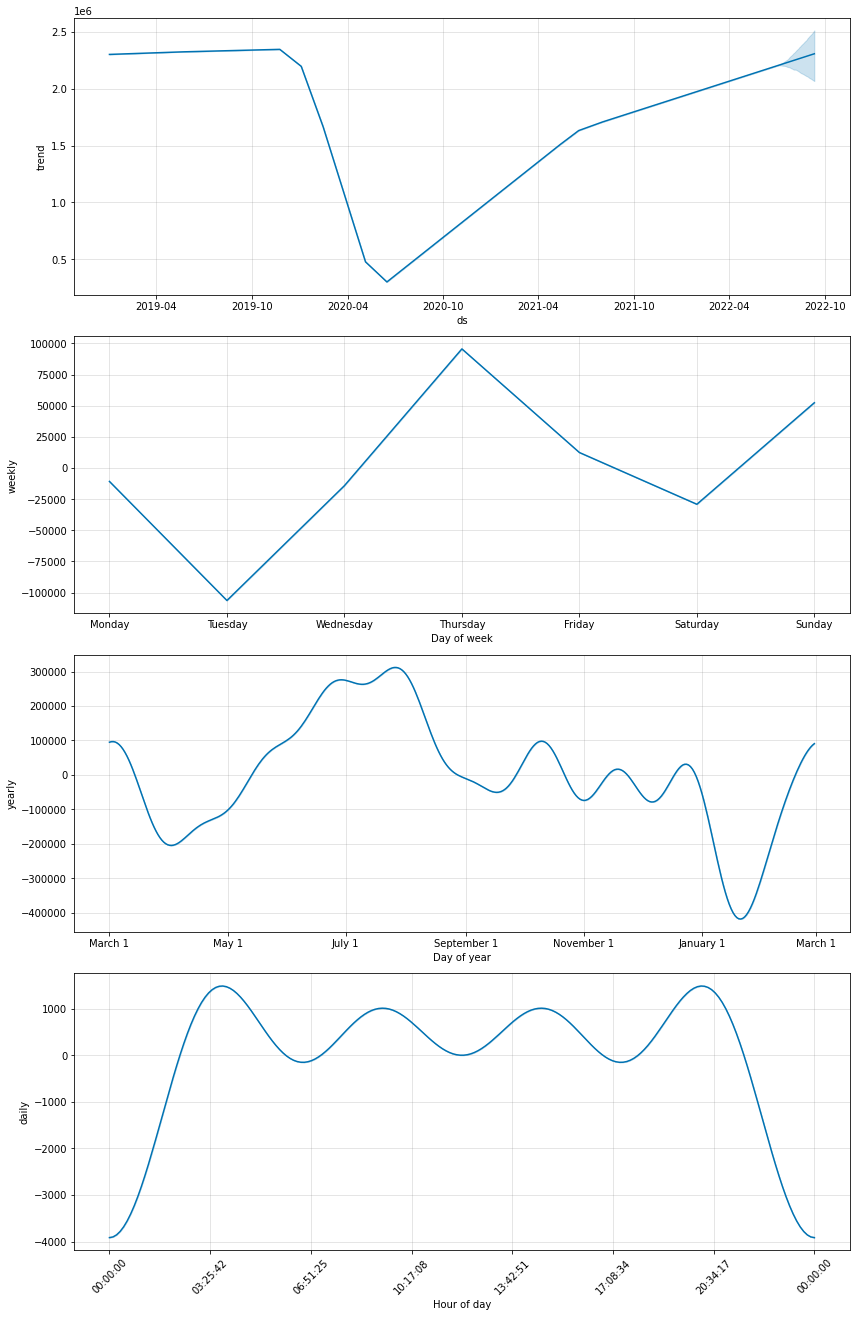

In [8]:
#plt.gca().set(title="Prophet prediction")
print("Prophet Seasonality and Predictions")
tt_model.plot_components(tt_pred, uncertainty=True, weekly_start=1, yearly_start=59, figsize=(12,18))
plt.xticks(rotation=45)
plt.show()

In [9]:
# Add Covid-19 'Holiday' to blunt false linear trend
covid_dates = pd.DataFrame({'ds':pd.date_range(start='3/15/2020', end='3/1/2022')})
covid =pd.DataFrame({'holiday':['Covid-19']})  # column with 'Covid-19' start to finish
covid_holiday = covid.join(covid_dates,how='outer').fillna('Covid-19')

tt_model_covid = Prophet(interval_width=0.95,  # 90% C.I. or is it?
                           yearly_seasonality=True, 
                           weekly_seasonality=True, 
                           daily_seasonality=True,
                           holidays=covid_holiday
                  )
#tt_model_covid.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=1)
#tt_model_covid.add_seasonality(name='yearly', period=365, fourier_order=10, prior_scale=1)
  
#Fit model
tt_model_covid.fit(train_travel)

#Predict the future
tt_future_covid = tt_model_covid.make_future_dataframe(periods=len(test_travel)) 
tt_pred_covid = tt_model_covid.predict(tt_future_covid)

### The effect of Covid-19 pandemic proved to be significant for air travel. Model RMSE improved significantly after introducing "covid holiday" period.

In [10]:
pred_test_covid = tt_pred_covid[tt_pred_covid['ds']>=test_travel['ds'][0]]['yhat']

# See how far off the predictions are from actual using RMSE
RMSE_covid = mean_squared_error(test_travel['travel_test'], pred_test_covid, squared=False)
print(f"Taking into account of Covid-19, treating it as holiday period, RMSE = {RMSE_covid:.3f}")
print(f"By adding special holiday, we reduced RMSE by {(RMSE - RMSE_covid)/RMSE*100:.2f}%")

Taking into account of Covid-19, treating it as holiday period, RMSE = 173634.188
By adding special holiday, we reduced RMSE by 30.80%


Prophet Seasonality and Predictions with Covid-19 Holiday added


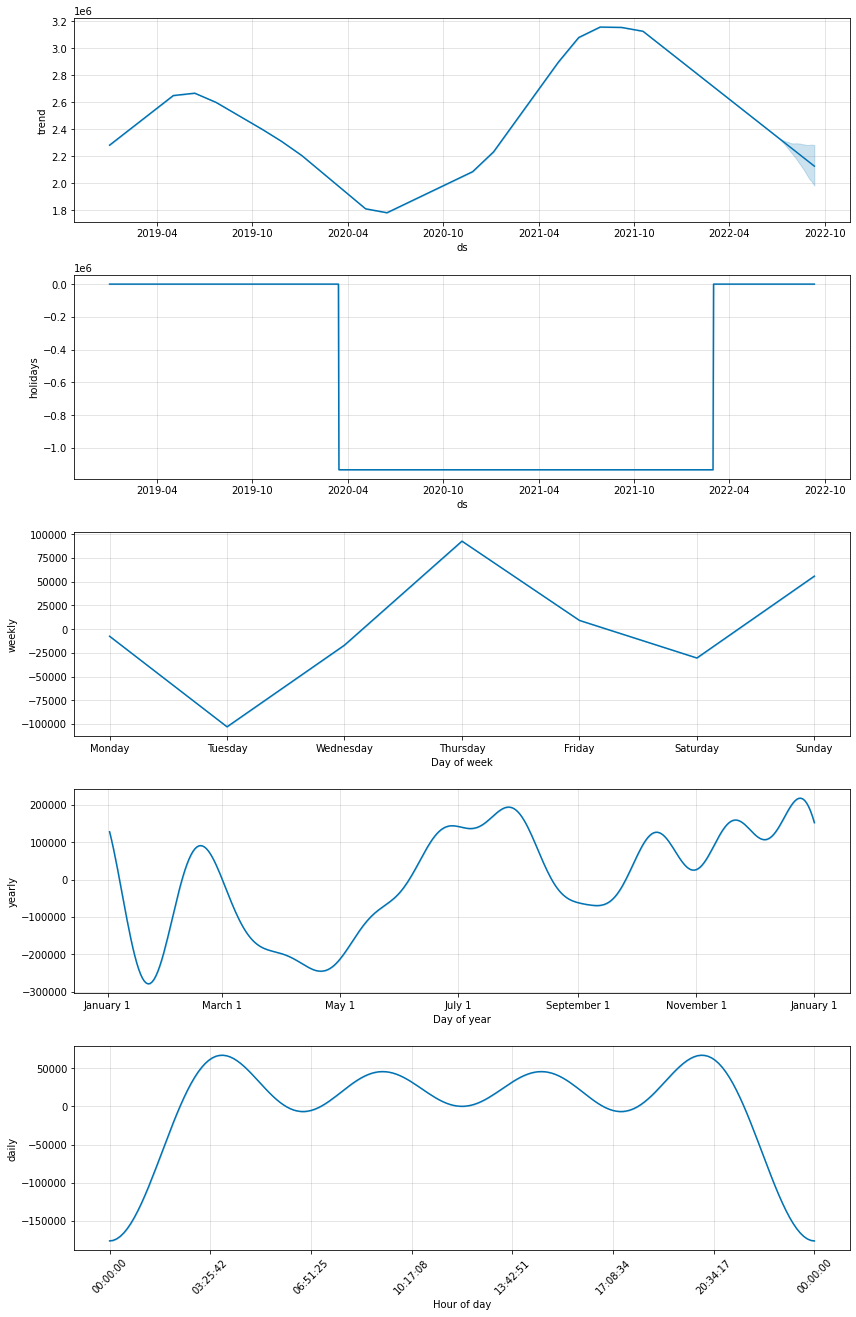

In [11]:
# Prophet plots with "holiday"
print("Prophet Seasonality and Predictions with Covid-19 Holiday added")
tt_model_covid.plot_components(tt_pred_covid, uncertainty=True, weekly_start=1, yearly_start=1, figsize=(12,18))
plt.xticks(rotation=45)
plt.show()

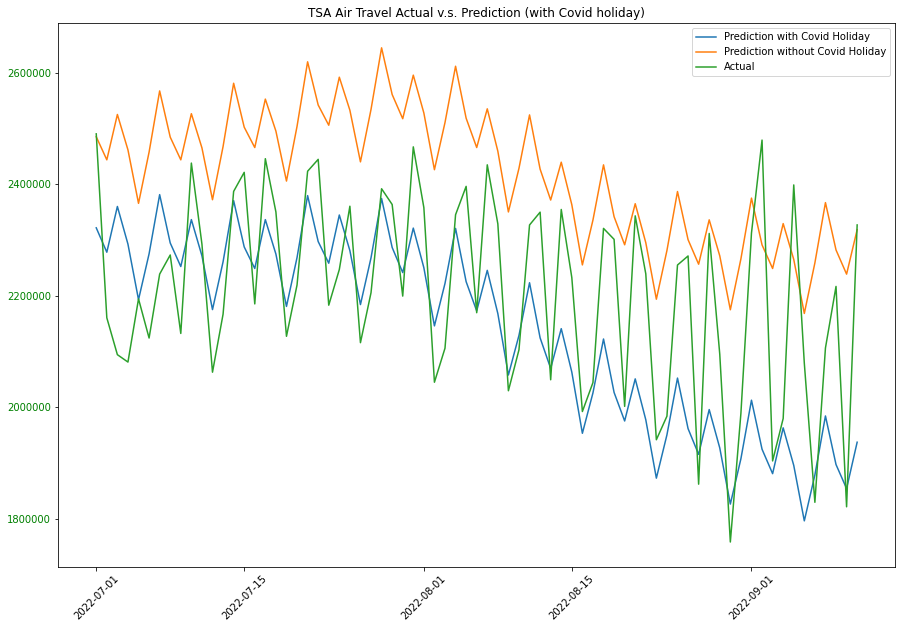

In [12]:
# Plot Actual v.s. Prediction (with and w/o Covid vacation)
plt.figure(figsize=(15,10))
plt.plot(test_travel['ds'], pred_test_covid, label='Prediction with Covid Holiday')
plt.plot(test_travel['ds'], pred_test, label='Prediction without Covid Holiday')
plt.plot(test_travel['ds'], test_travel['travel_test'], label='Actual')
    
#all that cosmetics
plt.gca().set(title='TSA Air Travel Actual v.s. Prediction (with Covid holiday)')
plt.gca().yaxis.set_major_formatter('{x:1.0f}') 
#plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
plt.gca().yaxis.set_tick_params(which='major', labelcolor='green')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Several other Covid holiday end dates produced smaller RMSE than 03/01/2022 as proposed in the assignment. Maybe some other force is at play here?

In [14]:
import datetime

# try to find the best holiday window 
#op_RMSE = 300000  # initialize to some large number
#op_period = 1

covid_holidays = pd.DataFrame(columns=['Date', 'RMSE'])

for i in np.arange(1, 730, 30):
    covid_dates = pd.DataFrame({'ds':pd.date_range(start='3/15/2020', periods=(i+1))})
    covid =pd.DataFrame({'holiday':['Covid-19']})
    covid_holiday = covid.join(covid_dates,how='outer').fillna('Covid-19')

    op_model_covid = Prophet(interval_width=0.95,  # 90% C.I. or is it?
                               yearly_seasonality=True, 
                               weekly_seasonality=True,
                               daily_seasonality=True,
                               holidays=covid_holiday                   
                      )
    #Fit model
    op_model_covid.fit(train_travel)

    #Predict the future
    op_future_covid = op_model_covid.make_future_dataframe(periods=len(test_travel)) 
    op_pred_covid = op_model_covid.predict(op_future_covid)
    op_pred_test_covid = op_pred_covid[op_pred_covid['ds']>=test_travel['ds'][0]]['yhat']

    to_date = datetime.date(2020, 3, 15) + datetime.timedelta(days = int(i))
    RMSE_temp = mean_squared_error(test_travel['travel_test'], op_pred_test_covid, squared=False)
    #print(f"If Covid holiday ends on {to_date}, prediction RMSE = {RMSE_temp:.3f}")
    covid_holidays.loc[i,:] = [to_date, RMSE_temp]

In [15]:
        
#op_date = datetime.date(2020, 3, 15) + datetime.timedelta(days = op_period)
op_RMSE = covid_holidays['RMSE'].min()
op_date = covid_holidays[covid_holidays['RMSE'] == op_RMSE]['Date']
print(f"Optimal holiday period ends on {op_date}, RMSE = {op_RMSE:.3f}")
print(f"The best reduced RMSE was {(RMSE - op_RMSE)/RMSE*100:.2f}%")

Optimal holiday period ends on 451    2021-06-09
Name: Date, dtype: object, RMSE = 131688.266
The best reduced RMSE was 47.52%


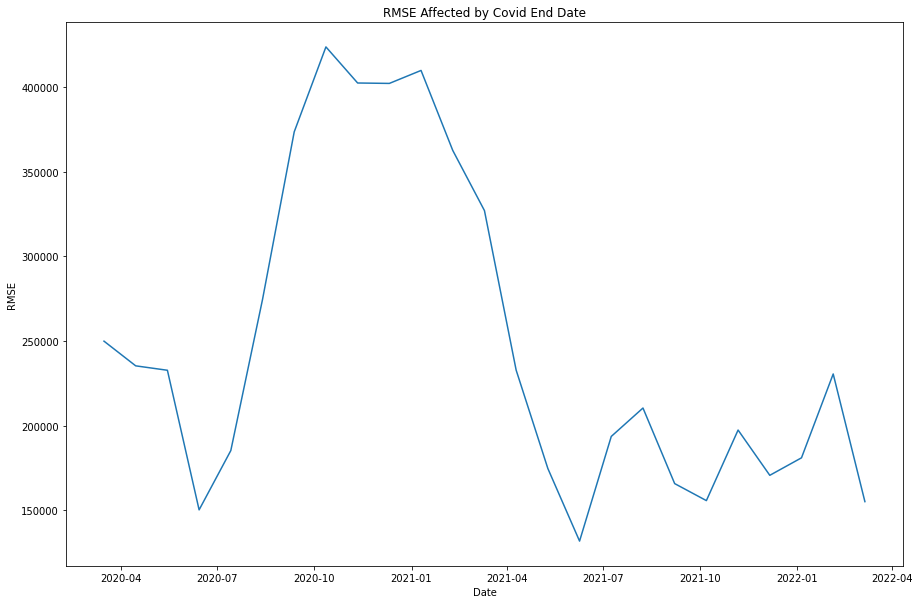

In [16]:
# Plot Actual v.s. Prediction (with and w/o Covid vacation)
plt.figure(figsize=(15,10))
plt.plot(covid_holidays['Date'], covid_holidays['RMSE'])
plt.gca().set(title='RMSE Affected by Covid End Date', xlabel='Date', ylabel='RMSE')
plt.show()